# Numerical Exercise 09

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from scipy.optimize import curve_fit
import statsmodels.api as sm
import math

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
selection = ["Exp law", "Roulette", "Tournament", "Stochastic"]
mapper = ["circle", "square", "provita"]

## Assigment
### Exercise 09.1

Write a code to solve the TSP with a **Genetic** algorithm (GA). Note that you should invent **some** *genetic-mutation* operators and a *genetic-crossover* operator which should preserve the bonds of the problem: the salesman must visit one and only one time every city and must be back to the first city in the end of the path.

Once the data structure of your code is ready, before you start coding your genetic operators, I warmly suggest you to code the creation of the starting population and to code a **check function** that verifies if every *individual* fulfils the bonds. Then check your starting population ... and use your check function every time you create a new individual.

You have to invent also a **selection** operator. 
The fitness and thus the order of the population should be obtained from $L^{(2)}(\vec{x}_1, \vec{x}_2, \dots, \vec{x}_N)$ or $L^{(1)}(\vec{x}_1, \vec{x}_2, \dots, \vec{x}_N)$. Once your starting population has been ordered on a fitness basis,
you have 2 possibilities:
1. write a selection operator which obtain the probability to select an individual from $L^{(2)}(\vec{x}_1, \vec{x}_2, \dots, \vec{x}_N)$ or $L^{(1)}(\vec{x}_1, \vec{x}_2, \dots, \vec{x}_N)$
2. write a selection operator which simply uses the order in the orderd population with $M$ individuals, e.g. select the individual $j$ with the algorithm: $j= int(M \times r^p)+1$ where $r$ is a uniform random number $r\in[0,1)$ and $p$ a convenient exponent. 

Set the first city to always appear at position 1, so as to reduce the degeneration of the shortest route to be 2, which corresponds to walking the shortest route in clockwise and anti-clockwise directions.

Then you can start introducing some *genetic-mutation* operators, for example:
1. pair permutation of cities (except for the first city), e.g. $\left[ 1, 2, 3, 4, 5 \right] \to \left[ 1, 2, 4, 3, 5 \right]$ (At this point you should already have such operator ... how have you generated the starting population?).
2. shift of $+n$ positions for $m$ contiguous cities (except for the first city and $m \lt N-1$), e.g. $\left[ 1, 2, 3, 4, 5 \right] \to \left[ 1, 4, 5, 2, 3 \right] $ for a $+2$ shift of the second and third cities.
3. permutation among $m$ contiguous cities (except for the first city) with other (different!) $m$ contiguous cities ($m<N/2$), e.g. $\left[ 1, 2, 3, 4, 5 \right] \to \left[ 1, 4, 5, 2, 3 \right] $ for a permutation of the second and third cities with the last 2.
4. inversion of the order in which they appear in the path of $m$ cities (except for the first city and $m \le N$), e.g. $\left[ 1, 2, 3, 4, 5 \right] \to \left[ 1, 4, 3, 2, 5 \right]$ for the inversion of the cities from 2 to 4.

Every mutation will have its probability, $p^{(i)}_m$ to be called and typically $p^{(i)}_m < 10\%$, but before to include crossover you can check if the GA is able to perform a good *random search* using only mutation operators (in this case $p^{(i)}$ could be higher than in the previous suggestion).

At this point you can add a *crossover* operator (that fulfils the bonds and that you will call with probability $p^{(i)}_c > 50\%$):

given a selected mother and father, e.g. 
$$
\left[ 1, 2, 3, 4, 5 \right]\\
\left[ 1, 5, 4, 3, 2 \right] 
$$
1. cut their paths at the same position:
$$
\left[ 1, 2, 3 | 4, 5 \right]\\
\left[ 1, 5, 4 | 3, 2 \right] 
$$
2. conserve the first part of the paths:
$$
\left[ 1, 2, 3 | X, Y \right]\\
\left[ 1, 5, 4 | X, Y \right] 
$$
3. complete the paths with the missing cities adding them in the **order** in which they appear in the consort:
$$
\left[ 1, 2, 3 | 5, 4 \right]\\
\left[ 1, 5, 4 | 2, 3 \right] 
$$

Here you are: you have two sons that you can add to the new generation ... and so on!

Apply your code to the optimization of a path among 

- 34 cities randomly placed **on** a circumference
- 34 cities randomly placed **inside** a square

Show your results via:

- a picture of $L^{(2)}$ (or $L^{(1)}$) of the best path and of $\langle L^{(2)}\rangle$ (or $\langle L^{(1)}\rangle$), averaged on the best half of the population, as a function of the iterations/generations of your algorithm
- a picture of the best path in cartesian coordinates

## Resolution
To approach this genetic algorithm problem, I have divided the pieces of the problem into 3 different classes.
- `Mapper` class: This class is responsible for mapping the cities in the cartesian plane and calculating the distance between them.
- `Population` class: This class is responsible for creating and managing the population.
- `BattleRoyale` class: This class is responsible for the genetic algorithm itself.

### Mapper
Once constructed with the number of cities with the method `Mapper(unsigned int n_cities)`, it needs to be filled. This is done through the method `Init<type>`:
    - `InitCircle`: Places the cities on a circumference.
    - `InitSquare`: Places the cities inside a square.
    - `InitCoords(arma::dmat coords)`: Places the cities in the coordinates given by the matrix `coords`. (this method is used for the provinces of Italy)
This class is responsable for calculating the distance between the cities with the method `double Distance(int first_city, int second_city)`. It also ha a method `virtual vector<double> Position(int city)` that returns the position of the city in the cartesian plane.

### Population
This class is responsible for creating and managing the population. It is constructed with the constructor `Population(shared_ptr<Mapper>& atlas, int n_populace)`. The population is enclosed inside the `public` attribute `arma::imat _apopulation`. It is a matrix of every chromosome in the population, stored as column vectors. This is done to have quick (although dirty and unsafe) access to the chromosomes.
The class also has a `vector<int> Check()` method which returns the eventual non correct chromosomes in the population. This method is used to check if the population is correct.

### BattleRoyale
This class is responsible for the genetic algorithm itself. It provides three `public` main methods:
- `void Reproduce(Population& pop)` which reproduces the population. This handles the selection and reproduction of the chromosomes. Once selected a pair of chromosomes with the method `int Selection(Population& pop)`, it generates two sons with the method `arma::imat Crossover(Population& pop, int first, int second)`
- `int Selection(Population& pop)` Returns the index of the selected chromosome. This method has 4 type of selection, settable at construct time:
    - `seltype = 0`: the selection follows the power law given by the assignment. 
    - `seltype = 1`: the selection is done the roulette wheel way.
    - `seltype = 2`: the selection is done through a tournament.
    - `seltype = 3`: the selection is done stochastic roulette.
- `void Mutation(Population& pop)` Handles all the possible mutations with their respective mutation rates. The mutations are private methods of the class:
    - `void Swap(Population &pop, int column)`: Swaps two cities in the chromosome.
    - `void Permutation(Population &pop, int column)`: Permutes two cities in the chromosome.
    - `void Shift(Population& pop, int column)`: Shifts a group of cities in the chromosome.
    - `void Inversion(Population& pop, int column)`: Inverts a group of cities in the chromosome.

A run of $N$ generations should look like this:
```cpp
for (int i{0}; i < N; i++) {
    br.Reproduce(pop);
    br.Mutation(pop);
}
```
### Results
Below are plotted results, for every type of `Mappper` (contains a spoiler for the next exercise, the provinces of Italy) and selection type. In addition to the length trend, I have provided plot of the absolute difference between the best path and the average of the best half of the population, and the mean overall. This is to show how quickly each type of selection converges to the best path, and how much it mutates.

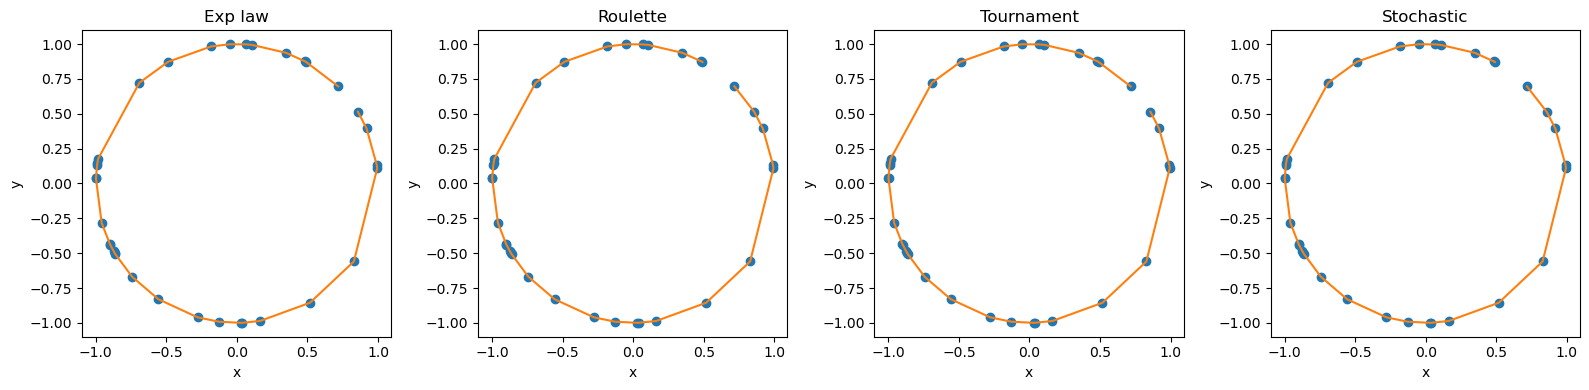

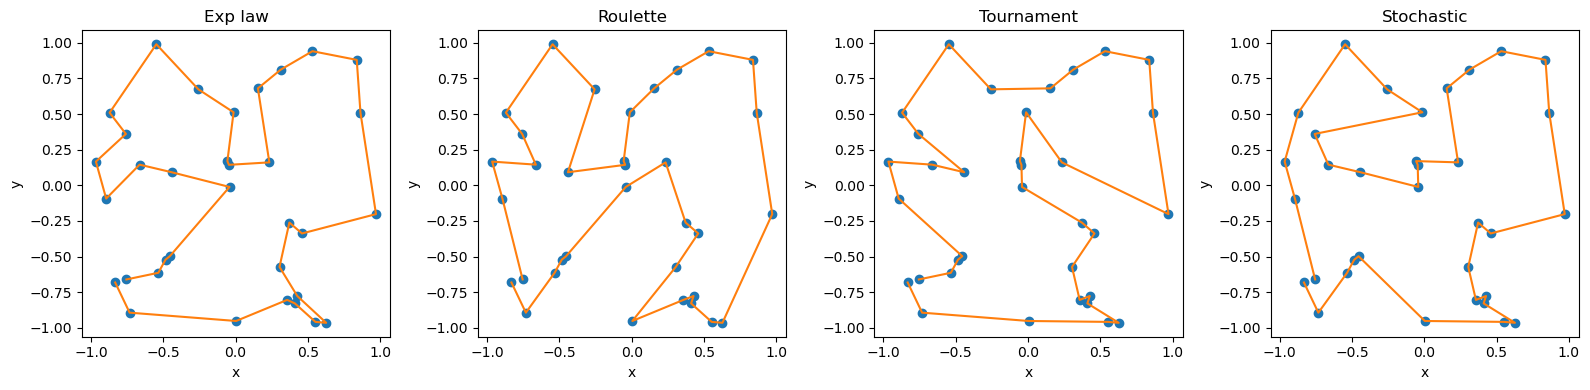

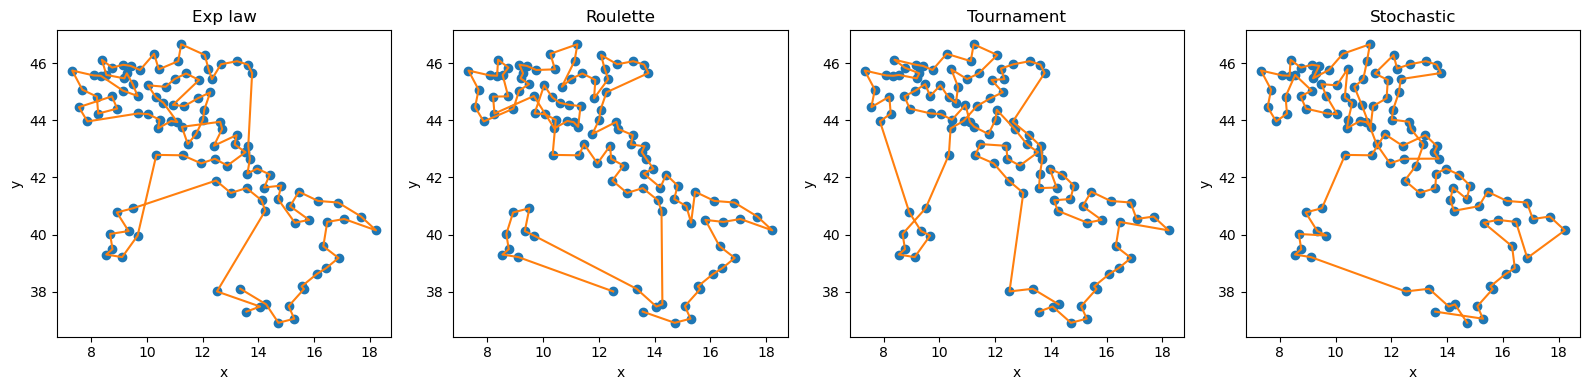

In [2]:
for atlas in mapper:
    x, y = np.loadtxt("../data/ex09_atlas_{atlante}.dat".format(atlante=atlas), unpack=True, usecols=(1, 2))
    fig = plt.figure(figsize=(16, 4))
    for i in range(0, 4):
        plt.subplot(1,4, i+1)
        plt.plot(x, y, marker='o', linestyle='None')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Plot of x and y')
        x1, y1 = np.loadtxt("../data/ex09_best_{atlante}_{sel}.dat".format(atlante=atlas, sel=i), unpack=True, usecols=(1, 2))
        plt.title(selection[i])
        plt.plot(x1, y1)
        plt.tight_layout()
    plt.show()

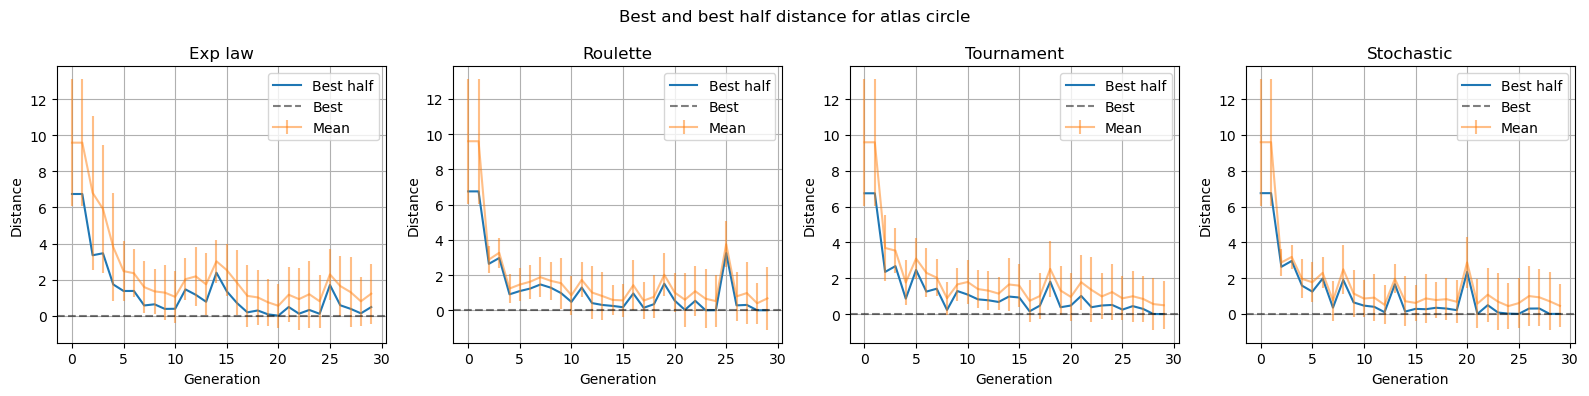

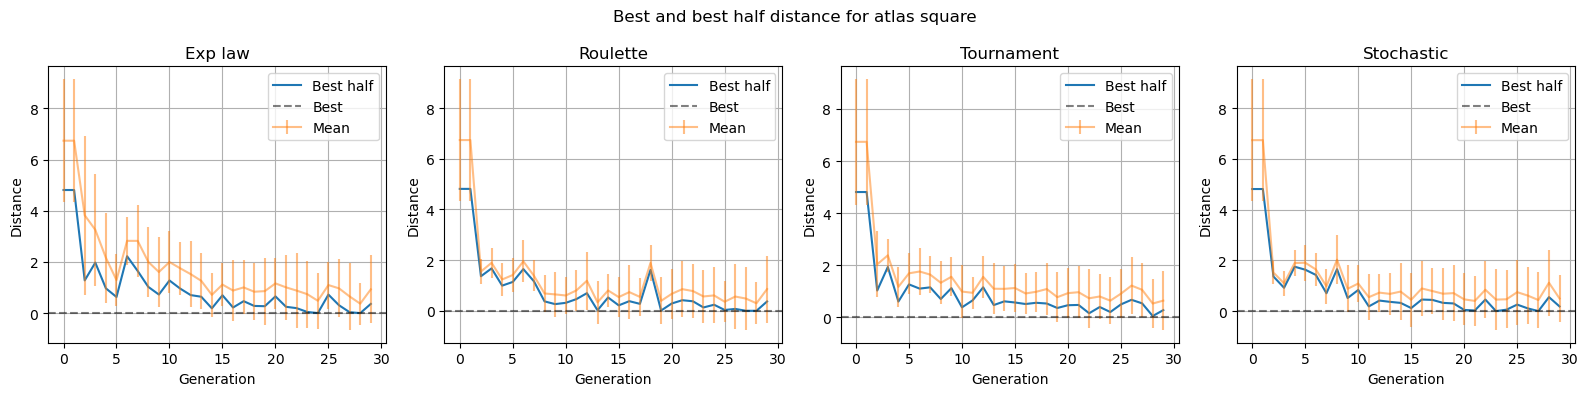

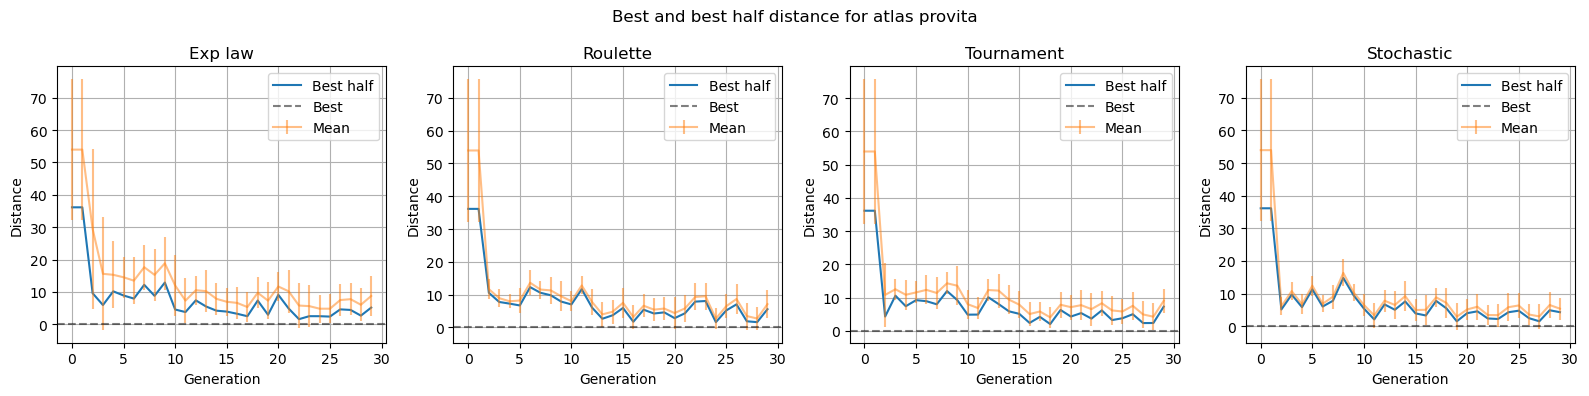

In [3]:
first = 30
for atlas in mapper:
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    for i in range(0, 4):
        n_gen, best, best_half, mean, std = np.loadtxt("../data/ex09_values_{atlante}_{i}.dat".format(atlante=atlas, i=i), unpack=True, usecols=(0, 1, 2, 3, 4))
        # ax[i].plot(n_gen[:first], best[:first], label="Best")
        ax[i].plot(n_gen[:first], abs(best_half[:first]-best[:first]), label="Best half")
        ax[i].errorbar(n_gen[:first], abs(mean[:first]-best[:first]), yerr=std[:first], label="Mean", alpha=0.5)
        ax[i].axhline(0, color='black', linestyle='--', alpha=0.5, label="Best")
        ax[i].set_xlabel("Generation")
        ax[i].set_ylabel("Distance")
        ax[i].set_title(selection[i])
        ax[i].legend()
        ax[i].grid()
    fig.suptitle("Best and best half distance for atlas {atlante}".format(atlante=atlas))
    plt.tight_layout()
    plt.show()


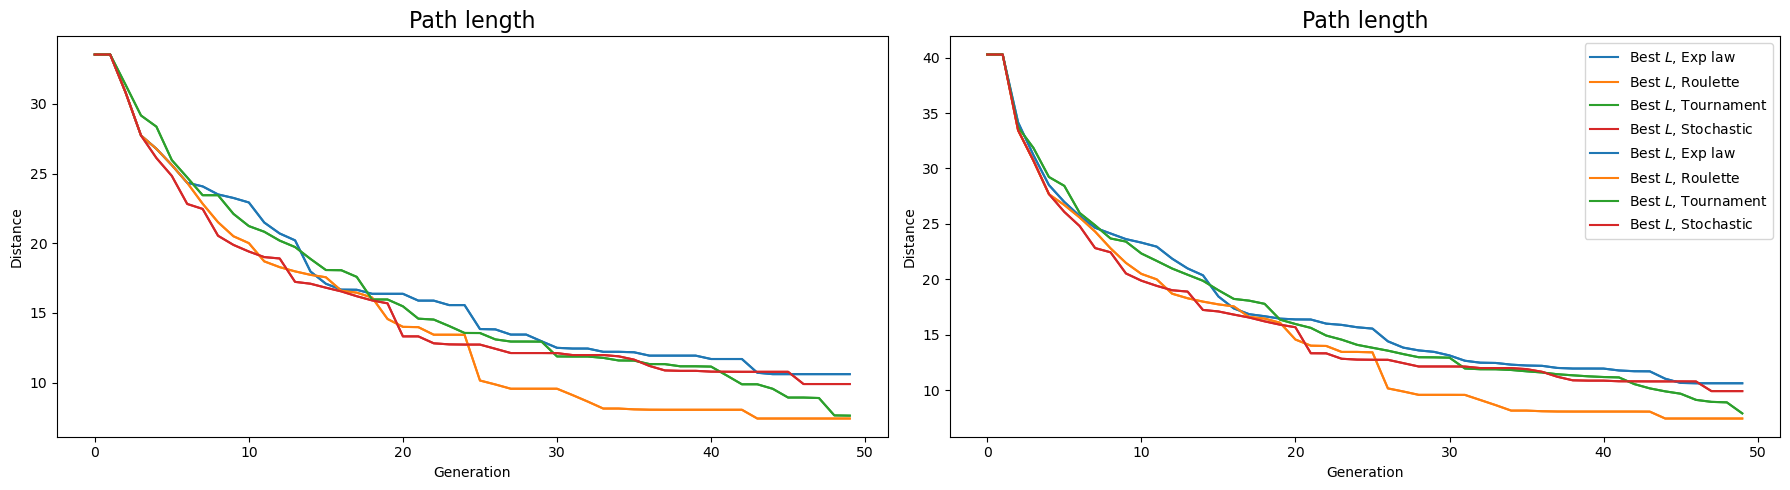

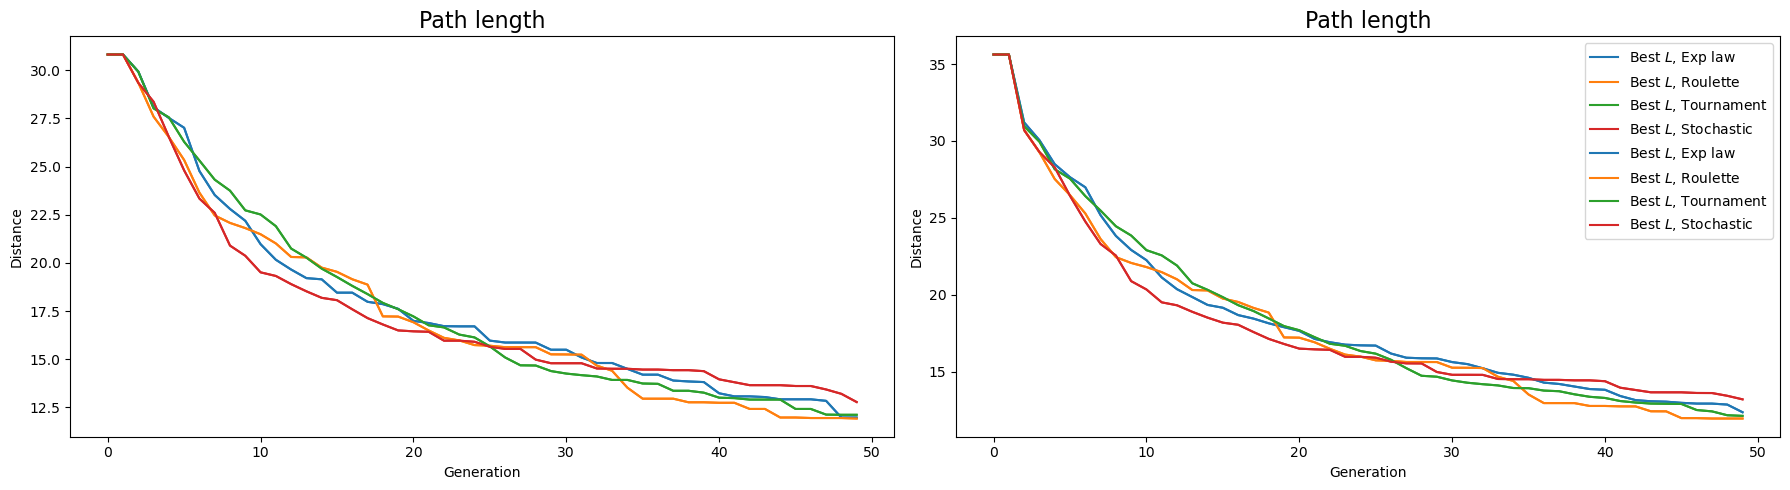

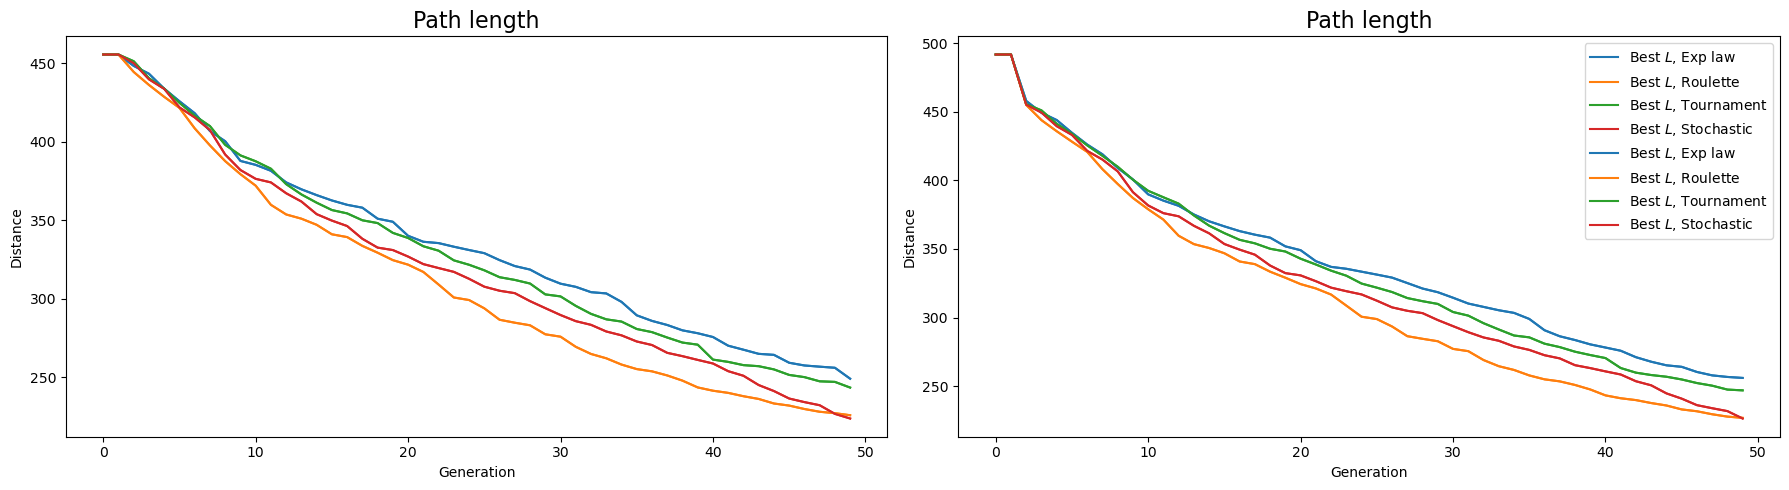

In [4]:
for atlas in mapper:
    fig = plt.figure(figsize=(18, 5))
    n_gen = []
    best_len = []
    best_half_len = []
    for i in range(4):
        n_gen.append(np.loadtxt("../data/ex09_values_{atlante}_{i}.dat".format(atlante=atlas, i=i), unpack=True, usecols=(0)))
        best_len.append(np.loadtxt("../data/ex09_values_{atlante}_{i}.dat".format(atlante=atlas, i=i), unpack=True, usecols=(1)))
        best_half_len.append(np.loadtxt("../data/ex09_values_{atlante}_{i}.dat".format(atlante=atlas, i=i), unpack=True, usecols=(2)))
    squaregen = 50
    np.sqrt(best_len)
    np.sqrt(best_half_len)
    for i in range(2):
        plt.subplot(1, 2, 1)
        plt.plot(n_gen[0][:squaregen], best_len[0][:squaregen], label=r"Best $L$, {sel}".format(sel=selection[0]), color=colors[0])
        plt.plot(n_gen[1][:squaregen], best_len[1][:squaregen], label=r"Best $L$, {sel}".format(sel=selection[1]), color=colors[1])
        plt.plot(n_gen[2][:squaregen], best_len[2][:squaregen], label=r"Best $L$, {sel}".format(sel=selection[2]), color=colors[2])
        plt.plot(n_gen[3][:squaregen], best_len[3][:squaregen], label=r"Best $L$, {sel}".format(sel=selection[3]), color=colors[3])
        plt.title('Path length', fontsize=16)
        plt.ylabel('Distance')
        plt.xlabel('Generation')
        plt.grid()
        plt.subplot(1, 2, 2)
        plt.plot(n_gen[0][:squaregen], best_half_len[0][:squaregen], label=r"Best $L$, {sel}".format(sel=selection[0]), color=colors[0])
        plt.plot(n_gen[1][:squaregen], best_half_len[1][:squaregen], label=r"Best $L$, {sel}".format(sel=selection[1]), color=colors[1])
        plt.plot(n_gen[2][:squaregen], best_half_len[2][:squaregen], label=r"Best $L$, {sel}".format(sel=selection[2]), color=colors[2])
        plt.plot(n_gen[3][:squaregen], best_half_len[3][:squaregen], label=r"Best $L$, {sel}".format(sel=selection[3]), color=colors[3])
        plt.title('Path length', fontsize=16)
        plt.ylabel('Distance')
        plt.xlabel('Generation')
        plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()